In [1]:
%config Completer.use_jedi = False

In [24]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import SubsetRandomSampler, DataLoader, Dataset
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, models, transforms

import numpy as np
import matplotlib.pyplot as plt
import time
import copy
import os

plt.rcParams["figure.figsize"] = (20,10)

In [3]:
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD = [0.229, 0.224, 0.225]
TRAIN_DATA_PATH = "data/train"
TEST_DATA_PATH = "data/test"

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [25]:
class ImageFolderWithPaths(datasets.ImageFolder):
    """Custom dataset that includes image file paths. Extends
    torchvision.datasets.ImageFolder
    """

    # override the __getitem__ method. this is the method that dataloader calls
    def __getitem__(self, index):
        # this is what ImageFolder normally returns 
        original_tuple = super(ImageFolderWithPaths, self).__getitem__(index)
        # the image file path
        path = self.imgs[index][0]
        # make a new tuple that includes original and the path
        tuple_with_path = (original_tuple + (os.path.basename(path),))
        return tuple_with_path

In [5]:
train_transforms = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD)
])

valid_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD)
])

In [26]:
train_data = datasets.ImageFolder(root=TRAIN_DATA_PATH, transform=train_transforms)
valid_data = datasets.ImageFolder(root=TRAIN_DATA_PATH, transform=valid_transforms)
test_data = ImageFolderWithPaths(root=TEST_DATA_PATH, transform=valid_transforms)

In [7]:
CLASS_NAMES = train_data.classes
NUM_CLASSES = len(CLASS_NAMES)
num_train = len(train_data)

indices = list(range(len(train_data)))
np.random.seed(42)
np.random.shuffle(indices)
split = int(np.floor(0.2 * len(train_data)))

In [8]:
train_idx, valid_idx = indices[split:], indices[:split]
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)
len(train_idx)

3800

In [9]:
train_loader = DataLoader(train_data, batch_size=32, sampler=train_sampler)
valid_loader = DataLoader(valid_data, batch_size=32, sampler=valid_sampler)

data_loaders = {"train": train_loader, "val": valid_loader}
data_sizes = {"train": len(train_idx), "val": len(valid_idx)}

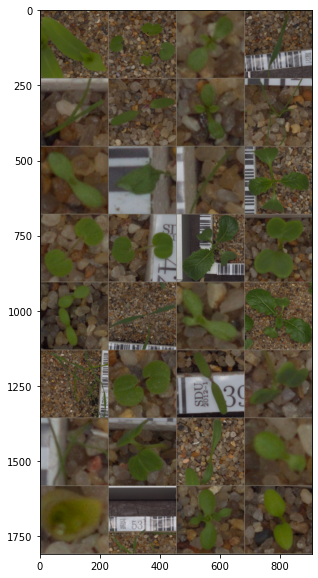

In [10]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array(IMAGENET_MEAN)
    std = np.array(IMAGENET_STD)
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(train_loader))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs, nrow=4)
imshow(out)

In [11]:
def train_model(model, criterion, optimizer, num_epochs, lr_scheduler, device="cpu"):
    since = time.time()
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    for epoch in range(num_epochs):
        print(f"Epoch {epoch}/{num_epochs-1}")
        print("-" * 10)
        
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()
            running_loss = 0.0
            running_corrects = 0
            
            for inputs, labels in data_loaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                optimizer.zero_grad()
                
                with torch.set_grad_enabled(phase=='train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, dim=1)
                    loss = criterion(outputs, labels)
                    
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                        
                running_loss += loss.item()*inputs.size(0)
                running_corrects += torch.sum(preds==labels.data)
            if phase == "train" and lr_scheduler:
                lr_scheduler.step()
            epoch_loss = running_loss/data_sizes[phase]
            epoch_acc = running_corrects.double()/data_sizes[phase]
                
            print(f"{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")
            
            if phase == "val" and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                
        print()
        
    time_elapsed = time.time() - since
    print(f"Training complete in {(time_elapsed//60):.3f}m {(time_elapsed%60):.3f}s")
    print(f"Best val acc: {best_acc:.4f}")
    model.load_state_dict(best_model_wts)
    return model                  

In [12]:
def visualize_model(model, num_images=16):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()
    
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(data_loaders["val"]):
            inputs = inputs.to(device)
            labels = labels.to(device)
            ouputs = model(inputs)
            _, preds = torch.max(ouputs, dim=1)
            
            for j in range(inputs.shape[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {CLASS_NAMES[preds[j]]} real {CLASS_NAMES[labels[j]]}')
                imshow(inputs.cpu().data[j])
                
                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)
            

In [13]:
model = models.resnet34(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, NUM_CLASSES)
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [14]:
# for epoch in range(20):
#     print(f"Epoch {epoch}/19 ")
#     for inputs, labels in train_loader:
#         inputs = inputs.to("cuda")
#         labels = labels.to("cuda")
#         optimizer.zero_grad()
#         outputs = model(inputs)
#         _, preds = torch.max(outputs, dim=1)
#         loss = criterion(outputs, labels)
#         loss.backward()
#         optimizer.step()

In [15]:
model_ft = train_model(model, criterion, optimizer, 18, exp_lr_scheduler, device)

Epoch 0/24
----------
train Loss: 0.9716 Acc: 0.6821
val Loss: 2.1053 Acc: 0.5421

Epoch 1/24
----------
train Loss: 0.5522 Acc: 0.8116
val Loss: 0.4994 Acc: 0.8137

Epoch 2/24
----------
train Loss: 0.4037 Acc: 0.8632
val Loss: 1.6869 Acc: 0.5411

Epoch 3/24
----------
train Loss: 0.3841 Acc: 0.8611
val Loss: 0.5091 Acc: 0.8105

Epoch 4/24
----------
train Loss: 0.2676 Acc: 0.9061
val Loss: 0.2690 Acc: 0.8905

Epoch 5/24
----------
train Loss: 0.2343 Acc: 0.9192
val Loss: 0.2627 Acc: 0.9116

Epoch 6/24
----------
train Loss: 0.2441 Acc: 0.9192
val Loss: 0.6890 Acc: 0.8316

Epoch 7/24
----------
train Loss: 0.1262 Acc: 0.9616
val Loss: 0.1353 Acc: 0.9537

Epoch 8/24
----------
train Loss: 0.0783 Acc: 0.9789
val Loss: 0.1212 Acc: 0.9621

Epoch 9/24
----------
train Loss: 0.0593 Acc: 0.9853
val Loss: 0.1170 Acc: 0.9579

Epoch 10/24
----------
train Loss: 0.0612 Acc: 0.9839
val Loss: 0.1201 Acc: 0.9621

Epoch 11/24
----------
train Loss: 0.0424 Acc: 0.9882
val Loss: 0.1126 Acc: 0.9632

Ep

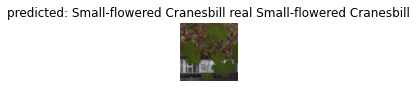

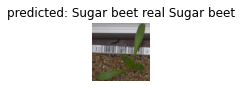

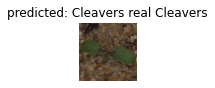

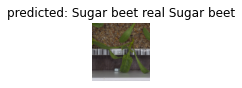

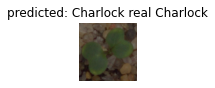

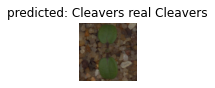

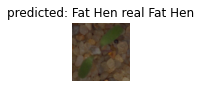

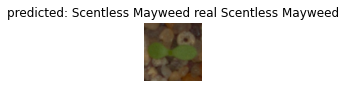

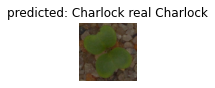

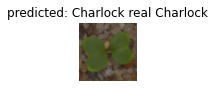

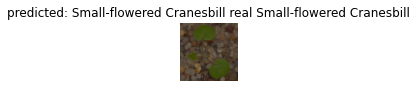

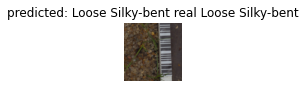

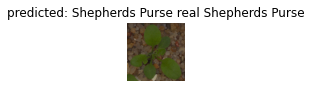

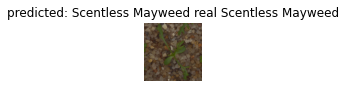

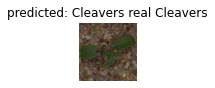

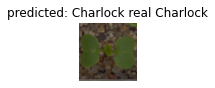

In [16]:
#visualize_model(model_ft)

In [17]:
#torch.save(model.state_dict(), "plant_seedlings_v2.pth")

In [30]:
res = []
test_loader = DataLoader(test_data, batch_size=32)
with torch.no_grad():
    for inputs, _, titles in test_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        predicted = [CLASS_NAMES[j] for j in predicted ]
        res += zip(titles, predicted)

In [31]:
import csv
with open("submission.csv", 'w') as csvfile:
    writer = csv.writer(csvfile)
    # header
    writer.writerow(["file", "species"])
    writer.writerows(res)